In [15]:
import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); Pkg.instantiate()
using LinearAlgebra
using ForwardDiff
using RobotZoo
using RobotDynamics
using Ipopt
using MathOptInterface
using TrajOptPlots
const MOI = MathOptInterface
using Random
using Plots
using Rotations
include("quadruped.jl")
include("sparseblocks.jl")
include("quadratic_cost.jl")
include("nlp.jl")
include("moi.jl")

  Activating environment at `C:\Users\pnadan\Documents\GitHub\Optimal-Control-Project\Project.toml`


solve

## Dynamics Models

In [219]:
include("simple_quadruped.jl")
full_model = UnitreeA1()
n,m = state_dim(full_model), control_dim(full_model)
mvis = initialize_visualizer(full_model);
model = simplifyQuadruped(full_model)
n,m = state_dim(model), control_dim(model);

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8709
└ @ MeshCat C:\Users\pnadan\.julia\packages\MeshCat\GlCMx\src\visualizer.jl:73


## Reference Trajectory & Contact Sequence

In [220]:
include("ref_trajectory.jl")
include("gait.jl")

# Discretization
tf = 4.4
dt = 0.1
N = Int(ceil(tf/dt)) + 1
times = range(0,tf, length=N);

# Reference Trajectory
Xref,Uref = reference_trajectory(model, times)

# Contact Sequence
M = 5 # NOTE: check later, is this physically feasible w/ our dt
contact_sched = contact_sequence_trot(times, M);

## Define NLP for IPOPT

In [221]:
include("moi.jl")
include("nlp.jl")
include("nlp_cost.jl")
include("nlp_constraint.jl")

# Define cost function
Q = Diagonal([1; 10; fill(1.0, 17); 1; 10; fill(1.0, 16)]);
# Q = Diagonal([1; 10; fill(1.0, 5); fill(0, 12); 1; 10; fill(1.0, 4); fill(0, 12)]);
R = Diagonal(fill(1e-3,12))
Qf = Q;
obj = map(1:N-1) do k
    LQRCost(Q,R,Xref[k],Uref[k])
end
push!(obj, LQRCost(Qf, R*0, Xref[N], Uref[1]))

# Unit test: constraint Jacobian matches result from ForwardDiff
let
    nlp = HybridNLP(model, obj, tf, N, M, Xref[1], Xref[end], contact_sched, use_sparse_jacobian=true);
    Random.seed!(1)
    Xguess = [x + 0.1*randn(length(x)) for x in Xref]
    Uguess = [u + 0.1*randn(length(u)) for u in Uref]
    Z0 = packZ(nlp, Xguess, Uguess);
    initialize_sparsity!(nlp)
    rc = getrc(nlp.blocks)
    r = [t[1] for t in rc]
    c = [t[2] for t in rc]
    jacvec = zeros(length(rc))
    jac_c!(nlp, jacvec, Z0)
    jac = sparse(NonzerosVector(jacvec, nlp.blocks));
    
    eval_c!(nlp, zeros(eltype(Z0), num_duals(nlp)), Z0)
    
#     jac_n = ForwardDiff.jacobian(x->eval_c!(nlp, zeros(eltype(x), num_duals(nlp)), x), Z0)
#     for i = 1:5
#         println(norm(jac[nlp.cinds[i],:] - jac_n[nlp.cinds[i],:]))
#     end
#     println(jac[nlp.cinds[4][1],1:n])
#     println(jac_n[nlp.cinds[4][1],1:n])
end


# Define the NLP
nlp = HybridNLP(model, obj, tf, N, M, Xref[1], Xref[end], contact_sched, use_sparse_jacobian=true);
Random.seed!(1)
Xguess = [x + 0.1*randn(length(x)) for x in Xref]
Uguess = [u + 0.1*randn(length(u)) for u in Uref]
Z0 = packZ(nlp, Xguess, Uguess);

LoadError: TypeError: in typeassert, expected Tuple{Vararg{Union{StaticArrays.Dynamic, Int64}, N} where N}, got a value of type Tuple{Tuple{Int64}}

## Solve NLP

In [ ]:
Z_sol, solver = solve(Z0, nlp, c_tol=1e-6, tol=1e-6, max_iter=100)

## Controller

In [ ]:
include("controller.jl")
Xsol,Usol = unpackZ(nlp,Z0)
A = [zeros(n,n) for k = 1:N-1]
B = [zeros(n,m) for k = 1:N-1]
for k = 1:N-1
    A[k], B[k] = discrete_jacobian(nlp.model, Xsol[k], Usol[k], nlp.times[k], nlp.times[k+1]-nlp.times[k], [0 0 0 0])
end
K, P = tvlqr(A,B,Q,R,Qf)

## Simulation

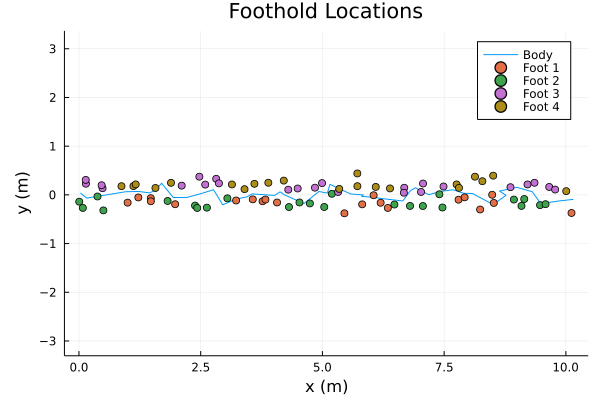

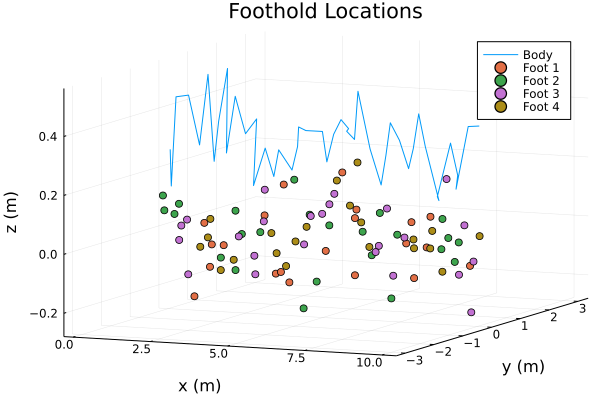

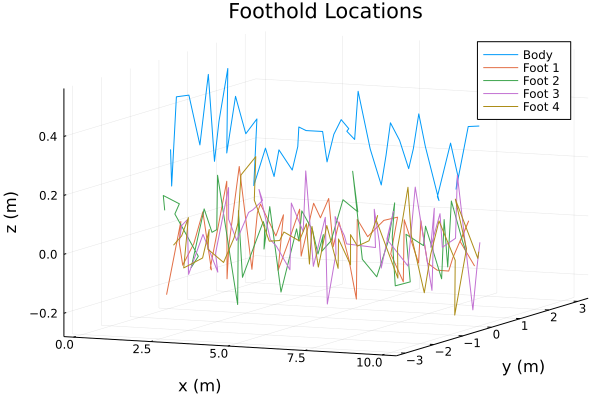

In [191]:
Xsol,Usol = unpackZ(nlp,Z0)
Xmat = zeros(N, n)
for k = 1:N
    Xmat[k,:] = Xsol[k]
end

f1 = nlp.modes[1,:] .== 0
f2 = nlp.modes[2,:] .== 0
f3 = nlp.modes[3,:] .== 0
f4 = nlp.modes[4,:] .== 0

# display(plot(nlp.times, Xmat[:,1:3], label = ["x" "y" "z"], xlabel="time (s)", ylabel="body position (m)"))
# display(plot(nlp.times, Xmat[:,8:10], label = ["x" "y" "z"], xlabel="time (s)", ylabel="foot 1 position (m)"))

plot(Xmat[:,1], Xmat[:,2], xlabel="x (m)", ylabel="y (m)", label = "Body")
scatter!(Xmat[f1,8], Xmat[:,9], label = "Foot 1")
scatter!(Xmat[f2,11], Xmat[:,12], label = "Foot 2")
scatter!(Xmat[f3,14], Xmat[:,15], label = "Foot 3")
display(scatter!(Xmat[f4,17], Xmat[:,18], label = "Foot 4", title="Foothold Locations", aspect_ratio = :equal))

plot3d(Xmat[:,1], Xmat[:,2], Xmat[:,3], xlabel="x (m)", ylabel="y (m)", zlabel="z (m)", label = "Body")
scatter3d!(Xmat[f1,8], Xmat[:,9], Xmat[:,10], label = "Foot 1")
scatter3d!(Xmat[f2,11], Xmat[:,12], Xmat[:,13], label = "Foot 2")
scatter3d!(Xmat[f3,14], Xmat[:,15], Xmat[:,16], label = "Foot 3")
display(scatter3d!(Xmat[f4,17], Xmat[:,18], Xmat[:,19], label = "Foot 4", title="Foothold Locations", aspect_ratio = :equal))

plot3d(Xmat[:,1], Xmat[:,2], Xmat[:,3], xlabel="x (m)", ylabel="y (m)", zlabel="z (m)", label = "Body")
plot3d!(Xmat[:,8], Xmat[:,9], Xmat[:,10], label = "Foot 1")
plot3d!(Xmat[:,11], Xmat[:,12], Xmat[:,13], label = "Foot 2")
plot3d!(Xmat[:,14], Xmat[:,15], Xmat[:,16], label = "Foot 3")
display(plot3d!(Xmat[:,17], Xmat[:,18], Xmat[:,19], label = "Foot 4", title="Foothold Locations", aspect_ratio = :equal))

## Model Limitations
* No impulse on body from foot impact
* Swing feet can slide on floor (instead of lifting off along some spline)
* No normal force limits
* No friction cone limits